## 1.Demonstration of reading XML and extracting frame 1 information

In [1]:
import cv2
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt

In [9]:
# ===== Path settings =====
img_path = './images/train/MVI_20011_img00001.jpg'
xml_path = './Train-Annotations/MVI_20011.xml'

# ===== Read Images and XML =====
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

tree = ET.parse(xml_path)
root = tree.getroot()

In [10]:
# ===== Visualize ignored_region =====
for box in root.find('ignored_region').findall('box'):
    x, y = float(box.get('left')), float(box.get('top'))
    w, h = float(box.get('width')), float(box.get('height'))
    cv2.rectangle(image, (int(x), int(y)), (int(x+w), int(y+h)), (50, 50, 50), 2)  # 深灰色框

# ===== Extract Frame 1 =====
first_frame = root.find(".//frame[@num='1']")
if first_frame is not None:
    for target in first_frame.find('target_list').findall('target'):
        tid = target.get('id')
        attr = target.find('attribute')
        vtype = attr.get('vehicle_type')
        orientation = attr.get('orientation')
        box = target.find('box')

        # Coordinate processing
        left = float(box.get('left'))
        top = float(box.get('top'))
        width = float(box.get('width'))
        height = float(box.get('height'))
        right = left + width
        bottom = top + height

        cv2.rectangle(image, (int(left), int(top)), (int(right), int(bottom)), (255, 0, 0), 2)

        # Display information: id + orientation + type
        label = f"id:{tid} {float(orientation):.1f}  {vtype}"
        cv2.putText(image, label, (int(left), int(top)-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

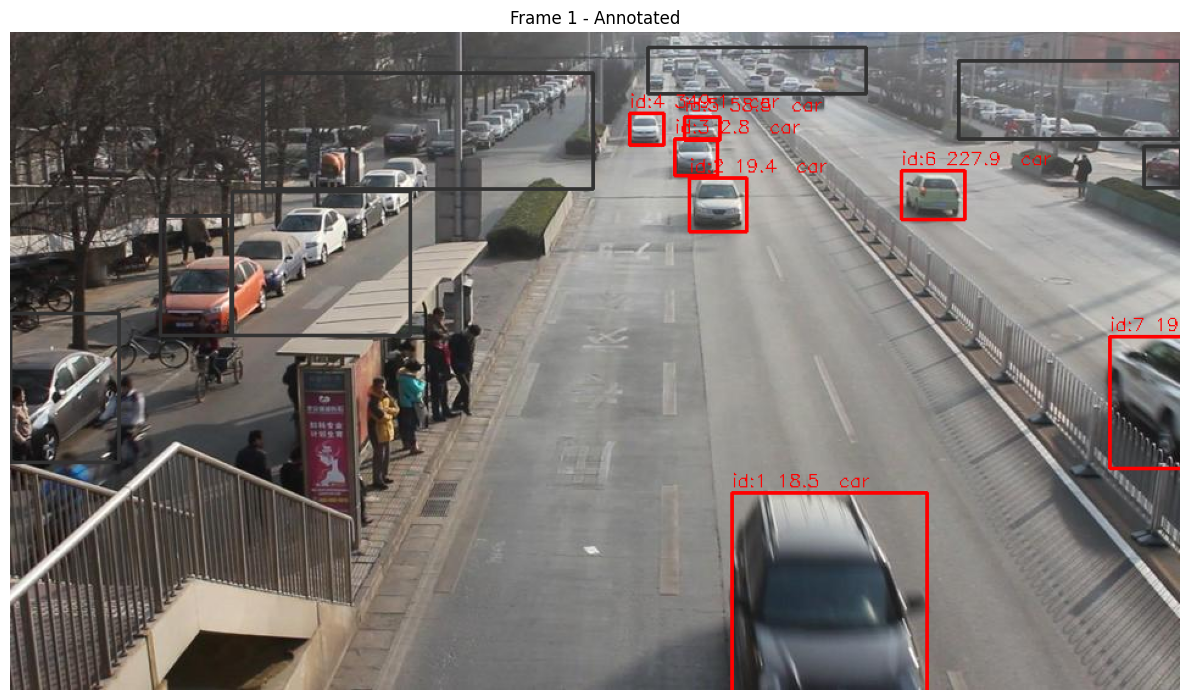

In [11]:
plt.figure(figsize=(12, 8))
plt.imshow(image)
plt.axis('off')
plt.title("Frame 1 - Annotated")
plt.tight_layout()
plt.show()

## 1.2 YOLO format label batch generation function

In [1]:
import os
import cv2
import xml.etree.ElementTree as ET
from tqdm import tqdm
from glob import glob

In [2]:
class_map = {'car': 0, 'bus': 1, 'van': 2, 'others': 3}

In [3]:
def convert_box_to_yolo(img_w, img_h, left, top, width, height):
    # Convert to YOLO normalized format
    x_center = (left + width / 2) / img_w
    y_center = (top + height / 2) / img_h
    w = width / img_w
    h = height / img_h
    return x_center, y_center, w, h

In [4]:
def process_dataset(annotation_dir, image_dir, output_dir, set_type='train'):
    os.makedirs(output_dir, exist_ok=True)
    class_map = {'car': 0, 'bus': 1, 'van': 2, 'others': 3}

    xml_files = glob(os.path.join(annotation_dir, '*.xml'))

    for xml_file in tqdm(xml_files, desc=f"Processing {set_type}"):
        video_id = os.path.splitext(os.path.basename(xml_file))[0]
        tree = ET.parse(xml_file)
        root = tree.getroot()

        frame_images = sorted(glob(os.path.join(image_dir, f"{video_id}_img*.jpg")))

        for frame_elem in root.findall('frame'):
            frame_num = int(frame_elem.attrib['num'])
            img_name = f"{video_id}_img{frame_num:05d}.jpg"
            img_path = os.path.join(image_dir, img_name)

            if not os.path.exists(img_path):
                continue

            img = cv2.imread(img_path)
            h, w = img.shape[:2]

            label_lines = []

            for target in frame_elem.find('target_list').findall('target'):
                attr = target.find('attribute')
                box = target.find('box')

                vehicle_type = attr.get('vehicle_type', 'others').lower()
                class_id = class_map.get(vehicle_type, 3)

                left = float(box.get('left'))
                top = float(box.get('top'))
                width = float(box.get('width'))
                height = float(box.get('height'))

                x, y, bw, bh = convert_box_to_yolo(w, h, left, top, width, height)

                # Remove orientation (YOLO expects only 5 values)
                line = f"{class_id} {x:.6f} {y:.6f} {bw:.6f} {bh:.6f}"
                label_lines.append(line)

            out_path = os.path.join(output_dir, f"{img_name.replace('.jpg', '.txt')}")
            with open(out_path, 'w') as f:
                f.write('\n'.join(label_lines))

In [5]:
# Create output directory 
os.makedirs("labels/train", exist_ok=True)
os.makedirs("labels/test", exist_ok=True)

In [6]:
# Perform training set label conversion
process_dataset(
    annotation_dir="Train-Annotations",
    image_dir="images/train",
    output_dir="labels/train",
    set_type='train'
)

Processing train: 100%|████████████████████████████████████████████████████████████████| 60/60 [08:03<00:00,  8.06s/it]


In [7]:
# Perform test set label conversion
process_dataset(
    annotation_dir="Test-Annotations",
    image_dir="images/test",
    output_dir="labels/test",
    set_type='test'
)

Processing test: 100%|█████████████████████████████████████████████████████████████████| 40/40 [05:55<00:00,  8.90s/it]


### YOLO Label Format Explanation

Each line in a YOLO label `.txt` file represents one object in the image and follows this format:

```
<class_id> <x_center> <y_center> <width> <height> <orientation>
```

#### Field Descriptions:

- `<class_id>`:  
  The integer ID of the object's class.  
  For example:  
  - `0` = car  
  - `1` = bus  
  - `2` = van  
  - `3` = others  

- `<x_center>` and `<y_center>`:  
  The normalized center coordinates of the bounding box (range [0, 1]).  
  They are calculated as:  
  ```
  x_center = (x_min + x_max) / 2 / image_width
  y_center = (y_min + y_max) / 2 / image_height
  ```


- `<width>` and `<height>`:  
  The normalized width and height of the bounding box (range [0, 1]).  
  They are calculated as:  
  ```
  width  = (x_max - x_min) / image_width
  height = (y_max - y_min) / image_height
  ```

#### Example:

```
0 0.700807 0.851667 0.166719 0.300370 
```

Means: A "car" located near the bottom-right of the image, oriented at 18.49 degrees.

> This format is commonly used when training models that require spatial and directional awareness, such as vehicle detection and tracking.
```


## 2.1 Demonstrate VOC-style RCNN labeling using the first frame

In [8]:
import os
import xml.etree.ElementTree as ET
import cv2
import torch
from glob import glob
import pprint

In [10]:
def parse_single_image_to_voc(xml_path, image_path, frame_num=1):
    # Read image size
    img = cv2.imread(image_path)
    h, w = img.shape[:2]

    tree = ET.parse(xml_path)
    root = tree.getroot()
    frame_elem = root.find(f".//frame[@num='{frame_num}']")

    if frame_elem is None:
        return None

    objects = []
    for target in frame_elem.find('target_list').findall('target'):
        attr = target.find('attribute')
        box = target.find('box')

        vehicle_type = attr.get('vehicle_type', 'others').lower()
        orientation = float(attr.get('orientation', 0))
        speed = float(attr.get('speed', 0))

        left = float(box.get('left'))
        top = float(box.get('top'))
        width = float(box.get('width'))
        height = float(box.get('height'))

        x_min = int(left)
        y_min = int(top)
        x_max = int(left + width)
        y_max = int(top + height)

        objects.append({
            "name": vehicle_type,
            "bndbox": {
                "xmin": x_min,
                "ymin": y_min,
                "xmax": x_max,
                "ymax": y_max
            },
            "orientation": orientation,
            "speed": speed 
        })

    return {
        "filename": image_path.split("/")[-1],
        "width": w,
        "height": h,
        "objects": objects
    }

# Example
image_path = './images/train/MVI_20011_img00001.jpg'
xml_path = './Train-Annotations/MVI_20011.xml'
voc_obj = parse_single_image_to_voc(xml_path, image_path)

pprint.pprint(voc_obj)

{'filename': 'MVI_20011_img00001.jpg',
 'height': 540,
 'objects': [{'bndbox': {'xmax': 752, 'xmin': 592, 'ymax': 541, 'ymin': 378},
              'name': 'car',
              'orientation': 18.488,
              'speed': 6.859},
             {'bndbox': {'xmax': 604, 'xmin': 557, 'ymax': 164, 'ymin': 120},
              'name': 'car',
              'orientation': 19.398,
              'speed': 1.5055},
             {'bndbox': {'xmax': 580, 'xmin': 545, 'ymax': 118, 'ymin': 88},
              'name': 'car',
              'orientation': 2.7525,
              'speed': 0.5206},
             {'bndbox': {'xmax': 536, 'xmin': 508, 'ymax': 93, 'ymin': 67},
              'name': 'car',
              'orientation': 349.06,
              'speed': 0.52707},
             {'bndbox': {'xmax': 582, 'xmin': 553, 'ymax': 89, 'ymin': 70},
              'name': 'car',
              'orientation': 58.543,
              'speed': 0.49822},
             {'bndbox': {'xmax': 783, 'xmin': 731, 'ymax': 154, 'ymin

## 2.2 Package XML into pt objects for storage, facilitating subsequent RCNN calls

In [11]:
import os
import xml.etree.ElementTree as ET
import cv2
import torch
from glob import glob
from tqdm import tqdm

In [12]:
def parse_video_to_voc_dict(xml_path, image_dir):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    video_id = root.attrib['name']

    frame_data = []

    for frame_elem in root.findall('frame'):
        frame_num = int(frame_elem.attrib['num'])
        img_name = f"{video_id}_img{frame_num:05d}.jpg"
        img_path = os.path.join(image_dir, img_name)

        if not os.path.exists(img_path):
            continue

        img = cv2.imread(img_path)
        h, w = img.shape[:2]

        objects = []
        for target in frame_elem.find('target_list').findall('target'):
            attr = target.find('attribute')
            box = target.find('box')

            vehicle_type = attr.get('vehicle_type', 'others').lower()
            orientation = float(attr.get('orientation', 0))
            speed = float(attr.get('speed', 0))

            left = float(box.get('left'))
            top = float(box.get('top'))
            width = float(box.get('width'))
            height = float(box.get('height'))

            x_min = int(left)
            y_min = int(top)
            x_max = int(left + width)
            y_max = int(top + height)

            objects.append({
                "name": vehicle_type,
                "bndbox": {
                    "xmin": x_min,
                    "ymin": y_min,
                    "xmax": x_max,
                    "ymax": y_max
                },
                "orientation": orientation,
                "speed": speed 
            })

        frame_data.append({
            "image_id": img_name.replace(".jpg", ""),
            "width": w,
            "height": h,
            "objects": objects
        })

    return frame_data

In [13]:
def batch_convert_to_pt(annotation_dir, image_dir, output_dir, set_type):
    os.makedirs(output_dir, exist_ok=True)
    xml_files = glob(os.path.join(annotation_dir, '*.xml'))

    for xml_path in tqdm(xml_files, desc=f"Processing {set_type}"):
        video_id = os.path.splitext(os.path.basename(xml_path))[0]
        voc_data = parse_video_to_voc_dict(xml_path, image_dir)
        save_path = os.path.join(output_dir, f"{video_id}.pt")
        torch.save(voc_data, save_path)

In [14]:
# Create Output Directory
os.makedirs("RCNN_labels/train", exist_ok=True)
os.makedirs("RCNN_labels/test", exist_ok=True)

In [15]:
# Perform training set label conversion
batch_convert_to_pt(
    annotation_dir="Train-Annotations",
    image_dir="images/train",
    output_dir="RCNN_labels/train",
    set_type="train"
)

Processing train: 100%|████████████████████████████████████████████████████████████████| 60/60 [07:59<00:00,  8.00s/it]


In [16]:
# Perform test set label conversion
batch_convert_to_pt(
    annotation_dir="Test-Annotations",
    image_dir="images/test",
    output_dir="RCNN_labels/test",
    set_type="test"
)

Processing test: 100%|█████████████████████████████████████████████████████████████████| 40/40 [05:31<00:00,  8.29s/it]


### R-CNN Data Format (VOC-style .pt)

In R-CNN training workflows, especially with custom datasets, it's common to use **Pascal VOC-style annotation structures**. In this project, each video is converted into a `.pt` file that contains annotations for all its frames.

---

#### Saved Format: `.pt` file (PyTorch serialized)

Each `.pt` file contains a list of Python dictionaries. Each dictionary represents **a single image (frame)** and includes:

```python
{
  "filename": "MVI_20011_img00001.jpg",   # Image name
  "width": 960,                           # Image width in pixels
  "height": 540,                          # Image height in pixels
  "objects": [                            # List of objects in this image
    {
      "name": "car",                      # Object class (e.g., car, bus)
      "bndbox": {                         # Pascal VOC bounding box
        "xmin": 592,
        "ymin": 378,
        "xmax": 752,
        "ymax": 541
      },
      "orientation": 18.49                # Vehicle heading (in degrees)
    },
    ...
  ]
}
```

---

- It is human-readable and extensible (e.g. you can add `occlusion`, `track_id`, etc.).
- It is compatible with **PyTorch-based models** via custom `Dataset` loaders.
- `.pt` files are more efficient for loading during training than parsing XML or JSON repeatedly.
- The structure matches Pascal VOC's core principles but with enhancements like `orientation`.
